In [1]:

import torch
import gc   
torch.cuda.empty_cache()
gc.collect()


0

In [2]:
print('dsdsdddddds')

dsdsdddddds


In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["OMP_NUM_THREADS"] = "1"

# Step 2: Import necessary libraries
from typing import Optional, Dict, Any
import os
import torch
import pytorch_lightning as pl
import pandas as pd
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from rich.traceback import install
from pytorch_lightning.loggers import WandbLogger
import torch.nn as nn
import torch.optim as optim
from transformers import AutoConfig, get_cosine_schedule_with_warmup
from adapters import AutoAdapterModel, AdapterConfig
from adapters.composition import Stack
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

install(show_locals=True)

from setup import setup_src_path
print(setup_src_path())
import data.processed as processed
import config.config as config
import utils.setup as setup
import utils.functions as fn
from importlib import reload

from datasets import load_from_disk

print(config.Config.TXT_SAVE_PATH)
print(config.Config.MODEL_SAVE_PATH)

dataset = load_from_disk(f"../{config.Config.DATASETS_SAVE_PATH}/datasets")


['/home/guest/Desktop/projects/fourth-expeiments/domain_adaptation_project/union/fiction', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages', '/tmp/tmpb_uqhwr5', '/home/guest/Desktop/projects/fourth-expeiments/domain_adaptation_project/modules']


2024-07-14 18:11:22.899043: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-14 18:11:23.087353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 18:11:23.873696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


./text-files/
./hp-model-


In [4]:
print('dsds')

dsds


In [5]:
# Step 4: Define the DomainTaskAdapter class



class DomainTaskAdapter(pl.LightningModule):
    def __init__(self, hparams):
        super(DomainTaskAdapter, self).__init__()
        self.save_hyperparameters(hparams)
        self.config = AutoConfig.from_pretrained(self.hparams["pretrained_model_name"])
        self.config.output_hidden_states = True
        self.model = AutoAdapterModel.from_pretrained(self.hparams["pretrained_model_name"], config=self.config)
        
        self.reduction_factor = self.hparams.get("reduction_factor", 16)
        if self.reduction_factor == "None":
            self.reduction_factor = 16
        self.leave_out = self.hparams.get("leave_out", [])
       
        self.saved_adapter_dir = self.hparams["saved_adapter_dir"]
        self.domain_adapter_name = self.hparams["domain_adapter_name"]
        
        adapter_config = AdapterConfig.load("seq_bn")
        
        self.task_adapter_name = self.hparams["task_adapter_name"]
        #self.model.add_adapter(self.task_adapter_name, config=adapter_config)

        self.model.load_adapter(f"{self.saved_adapter_dir}/{self.domain_adapter_name}", with_head=False)
        self.model.add_classification_head(self.task_adapter_name, num_labels=self.hparams["num_classes"])
        self.model.active_adapters = self.domain_adapter_name

        self.model.train_adapter(self.domain_adapter_name)
        print(self.model.adapter_summary())
        print(fn.print_trainable_parameters(self.model))

        self.training_outputs = []
        self.validation_outputs = []
        self.test_outputs = []
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass',                                           
                                     num_classes=self.hparams["num_classes"])
        self.f1 = torchmetrics.F1Score(task='multiclass',num_classes=self.hparams["num_classes"], average="weighted")
        self.f1_macro = torchmetrics.F1Score(task='multiclass',num_classes=self.hparams["num_classes"], average="macro")
        self.f1_micro = torchmetrics.F1Score(task='multiclass',num_classes=self.hparams["num_classes"], average="micro")
        self.softmax = nn.Softmax(dim=1)
        self.entropy_values = []  # For entropy minimization
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits,outputs.hidden_states[-1]

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask = batch["source_input_ids"], batch["source_attention_mask"]
        labels = batch["label_source"]
        logits,_ = self(input_ids=input_ids, attention_mask=attention_mask)
        loss = self.criterion(logits, labels)
        accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))
        # self.training_outputs.append({
        #     "train_loss": loss,
        #     "train_accuracy":accuracy,
        #     "train_f1":f1,
        #     })
        self.log("train_loss", loss)
        self.log("train_accuracy", accuracy)
        self.log("train_f1", f1)
        
        return loss
   
    def validation_step(self, batch, batch_idx):
        """validation step of DomainTaskAdapter"""
        # get the input ids and attention mask for source data
        input_ids, attention_mask = batch["source_input_ids"], batch["source_attention_mask"]
        logits,features = self(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch["label_source"]
        source_loss = self.criterion(logits, labels)
        source_accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        source_f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))


        # get the input ids and attention mask for target data
        input_ids, attention_mask = batch["target_input_ids"], batch["target_attention_mask"]
        logits ,target_features = self(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch["label_target"]
        target_loss = self.criterion(logits, labels)
        target_accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        target_f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))
        # # Entropy minimization - calculate and log entropy
        # probs = self.softmax(logits).cpu().numpy()
        # entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)
        # avg_entropy = np.mean(entropy)
        # self.entropy_values.append(avg_entropy)
     
        # this will log the mean div value across epoch
        self.log(name="source_val/loss", value=source_loss, prog_bar=True, logger=True)
        self.log(name="source_val/accuracy", value=source_accuracy, prog_bar=True, logger=True)
        self.log(name="source_val/f1", value=source_f1, prog_bar=True, logger=True)
        self.log(name="target_val/loss", value=target_loss, prog_bar=True, logger=True)
        self.log(name="target_val/accuracy", value=target_accuracy, prog_bar=True, logger=True)
        self.log(name="target_val/f1", value=target_f1, prog_bar=True, logger=True)
        
        self.validation_outputs.append({
            "source_val/loss": source_loss,
            "source_val/accuracy": source_accuracy,
            "source_val/f1": source_f1,
            "target_val/loss": target_loss,
            "target_val/accuracy": target_accuracy,
            "target_val/f1": target_f1,
            "features": target_features.cpu(),  # Collect features for t-SNE
            "logits": logits.cpu(),  # Collect logits for confusion matrix
            "labels": labels.cpu()  # Collect labels for confusion matrix   
                })
        return {
            "source_val/loss": source_loss,
            "source_val/accuracy": source_accuracy,
            "source_val/f1": source_f1,
            "target_val/loss": target_loss,
            "target_val/accuracy": target_accuracy,
            "target_val/f1": target_f1,
            "features": target_features.cpu(),  # Collect features for t-SNE
            "logits": logits.cpu(),  # Collect logits for confusion matrix
            "labels": labels.cpu()  # Collect labels for confusion matrix   
                            }
    def on_validation_epoch_start(self):
        self.validation_outputs = []
    
    def on_validation_epoch_end(self):
        try:
            outputs= self.validation_outputs
            mean_source_loss = torch.stack([x["source_val/loss"] for x in outputs]).mean()
            mean_source_accuracy = torch.stack([x["source_val/accuracy"] for x in outputs]).mean()
            mean_source_f1 = torch.stack([x["source_val/f1"] for x in outputs]).mean()

            mean_target_loss = torch.stack([x["target_val/loss"] for x in outputs]).mean()
            mean_target_accuracy = torch.stack([x["target_val/accuracy"] for x in outputs]).mean()
            mean_target_f1 = torch.stack([x["target_val/f1"] for x in outputs]).mean()
            print(f"target_val/loss: {mean_target_loss}")
            print(f"target_val/accuracy: {mean_target_accuracy}")
            print(f"target_val/f1: {mean_target_f1}")
            print(f"source_val/loss: {mean_source_loss}")
            print(f"source_val/accuracy: {mean_source_accuracy}")
            print(f"source_val/f1: {mean_source_f1}")

            self.log(name="source_val/loss", value=mean_source_loss, prog_bar=True, logger=True)
            self.log(name="source_val/accuracy", value=mean_source_accuracy, prog_bar=True, logger=True)
            self.log(name="target_val/loss", value=mean_target_loss, prog_bar=True, logger=True)
            self.log(name="target_val/accuracy", value=mean_target_accuracy, prog_bar=True, logger=True)
            self.log(name="target_val/f1", value=mean_target_f1, prog_bar=True, logger=True)
            self.log(name="source_val/f1", value=mean_source_f1, prog_bar=True, logger=True)
        
        
            self.log("val_loss", mean_source_loss)
            #Generate and log visualizations
            if hasattr(self.trainer, 'current_epoch'):
                self.plot_tsne(outputs, epoch=self.trainer.current_epoch, phase='validation')
                self.plot_confusion_matrix(outputs, phase='validation')
        except Exception as e:
            print(f"Error during on_validation_epoch_end: {e}")
            raise

    def test_step(self, batch, batch_idx):
        """validation step of DomainTaskAdapter"""
        # get the input ids and attention mask for source data
        input_ids, attention_mask = batch["source_input_ids"], batch["source_attention_mask"]
        logits,features  = self(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch["label_source"]
        source_loss = self.criterion(logits, labels)
        source_accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        source_f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))
        source_f1_macro = self.f1_macro(labels, torch.argmax(self.softmax(logits), dim=1))
        source_f1_micro = self.f1_micro(labels, torch.argmax(self.softmax(logits), dim=1))

        # get the input ids and attention mask for target data
        input_ids, attention_mask = batch["target_input_ids"], batch["target_attention_mask"]
        logits,target_features = self(input_ids=input_ids, attention_mask=attention_mask)
        labels = batch["label_target"]
        target_loss = self.criterion(logits, labels)
        target_accuracy = self.accuracy(labels, torch.argmax(self.softmax(logits), dim=1))
        target_f1 = self.f1(labels, torch.argmax(self.softmax(logits), dim=1))
        target_f1_macro = self.f1_macro(labels, torch.argmax(self.softmax(logits), dim=1))
        target_f1_micro = self.f1_micro(labels, torch.argmax(self.softmax(logits), dim=1))

       

        self.log(name="source_test/loss", value=source_loss, logger=True)
        self.log(name="source_test/accuracy", value=source_accuracy, logger=True)
        self.log(name="source_test/f1", value=source_f1, logger=True)
        self.log(name="source_test/f1_macro", value=source_f1_macro, logger=True)
        self.log(name="source_test/f1_micro", value=source_f1_micro, logger=True)
        self.log(name="target_test/loss", value=target_loss, logger=True)
        self.log(name="target_test/accuracy", value=target_accuracy, logger=True)
        self.log(name="target_test/f1", value=target_f1, logger=True)
        self.log(name="target_test/f1_macro", value=target_f1_macro, logger=True)
        self.log(name="target_test/f1_micro", value=target_f1_micro, logger=True)
        
        self.test_outputs.append({
            "source_test/loss": source_loss,
            "source_test/accuracy": source_accuracy,
            "source_test/f1": source_f1,
            "source_test/f1_macro": source_f1_macro,
            "source_test/f1_micro": source_f1_micro,
            "target_test/loss": target_loss,
            "target_test/accuracy": target_accuracy,
            "target_test/f1": target_f1,
            "target_test/f1_macro": target_f1_macro,
            "target_test/f1_micro": target_f1_micro,

            "features": target_features.cpu(),  # Collect features for t-SNE
            "logits": logits.cpu(),  # Collect logits for confusion matrix
            "labels": labels.cpu()  # Collect labels for confusion matrix   
        })
        return {
            "source_test/loss": source_loss,
            "source_test/accuracy": source_accuracy,
            "source_test/f1": source_f1,
            "source_test/f1_macro": source_f1_macro,
            "source_test/f1_micro": source_f1_micro,

            "target_test/loss": target_loss,
            "target_test/accuracy": target_accuracy,
            "target_test/f1": target_f1,
            "target_test/f1_macro": target_f1_macro,
            "target_test/f1_micro": target_f1_micro,

            "features": target_features.cpu(),  # Collect features for t-SNE
            "logits": logits.cpu(),  # Collect logits for confusion matrix
            "labels": labels.cpu()  # Collect labels for confusion matrix   
        }
    def on_test_epoch_start(self):
        self.test_outputs = []
    def on_test_epoch_end(self):
        try:
            outputs=  self.test_outputs
            mean_source_loss = torch.stack([x["source_test/loss"] for x in outputs]).mean()
            mean_source_accuracy = torch.stack([x["source_test/accuracy"] for x in outputs]).mean()
            mean_source_f1 = torch.stack([x["source_test/f1"] for x in outputs]).mean()
            mean_source_f1_macro = torch.stack([x["source_test/f1_macro"] for x in outputs]).mean()
            mean_source_f1_micro = torch.stack([x["source_test/f1_micro"] for x in outputs]).mean()

            mean_target_loss = torch.stack([x["target_test/loss"] for x in outputs]).mean()
            mean_target_accuracy = torch.stack([x["target_test/accuracy"] for x in outputs]).mean()
            mean_target_f1 = torch.stack([x["target_test/f1"] for x in outputs]).mean()
            mean_target_f1_macro = torch.stack([x["target_test/f1_macro"] for x in outputs]).mean()
            mean_target_f1_micro = torch.stack([x["target_test/f1_micro"] for x in outputs]).mean()

            self.log(name="source_test/loss", value=mean_source_loss)
            self.log(name="source_test/accuracy", value=mean_source_accuracy)
            self.log(name="source_test/f1", value=mean_source_f1)
            self.log(name="source_test/f1_macro", value=mean_source_f1_macro)
            self.log(name="source_test/f1_micro", value=mean_source_f1_micro)
            self.log(name="target_test/loss", value=mean_target_loss)
            self.log(name="target_test/accuracy", value=mean_target_accuracy)
            self.log(name="target_test/f1", value=mean_target_f1)
            self.log(name="target_test/f1_macro", value=mean_target_f1_macro)
            self.log(name="target_test/f1_micro", value=mean_target_f1_micro)


            # Generate and log visualizations
            if hasattr(self.trainer, 'current_epoch'):
                self.plot_tsne(outputs, epoch=self.trainer.current_epoch, phase='test')
                self.plot_confusion_matrix(outputs, phase='test')
        except Exception as e:
            print(f"Error during on_test_epoch_end: {e}")
            raise
    def save_adapter(self, location, adapter_name):
        self.model.save_adapter(location, adapter_name)
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams["learning_rate"])
        lr_scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, cooldown=0, min_lr=1e-8),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]
    def plot_tsne(self, outputs, epoch, phase):
        try:
            features = []
            labels = []
            for output in outputs:
                features.extend(output["features"].numpy())  # Use target features
                labels.extend(output["labels"].numpy())  # Use target labels

            features = np.array(features)
            labels = np.array(labels)
            print(f"Features shape: {features.shape}")
            print(f"Labels shape: {labels.shape}")

            # Flatten features if necessary
            if features.ndim > 2:
                features = features.reshape(features.shape[0], -1)
                print(f"Flattened features shape: {features.shape}")

            tsne = TSNE(n_components=2)
            tsne_results = tsne.fit_transform(features)
            plt.figure(figsize=(8, 4))
            for i in range(self.hparams["num_classes"]):
                idxs = np.where(labels == i)
                plt.scatter(tsne_results[idxs, 0], tsne_results[idxs, 1], label=f'Class {i}')
            plt.legend()
            plt.title(f't-SNE plot {phase} Epoch {epoch}')
            plt.show()  # Display the plot inline
        except Exception as e:
            print(f"Error during t-SNE plotting: {e}")
            raise

    def plot_confusion_matrix(self, outputs, phase):
        try:
            y_true = []
            y_pred = []
            for output in outputs:
                y_true.extend(output["labels"].numpy())  # Use target labels
                y_pred.extend(torch.argmax(output["logits"], dim=1).numpy())  # Use predicted labels from logits

            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            print(f"y_true shape: {y_true.shape}")
            print(f"y_pred shape: {y_pred.shape}")

            cm = confusion_matrix(y_true, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.title(f'Confusion Matrix {phase}')
            plt.show()  # Display the plot inline
        except Exception as e:
            print(f"Error during confusion matrix plotting: {e}")
            raise

In [6]:
# Step 5: Training and Evaluation Loop with Wandb logging
import wandb
wandb.login()
# Wandb setup and training loop
seeds = [42,10,100]  # List of seeds
project_name = 'ablations'  # Replace with your wandb project name
domain = 'SF'  # Replace with the specific domain for this notebook
type = 'union_macro'  # Replace with the specific type for this notebook
domain_aprev ='SF'

# Initialize results dictionary
results = {
    "last_epoch": {
        
        "source_test/loss": [],
        "source_test/accuracy": [],
        "source_test/f1": [],        
        "source_test/f1_macro": [],
        "source_test/f1_micro": [],
        "target_test/loss": [],
        "target_test/accuracy": [],
        "target_test/f1": [],
        "target_test/f1_macro": [],
        "target_test/f1_micro": [],
    },
    "best_model": {
        
        "source_test/loss": [],
        "source_test/accuracy": [],
        "source_test/f1": [],        
        "source_test/f1_macro": [],
        "source_test/f1_micro": [],
        "target_test/loss": [],
        "target_test/accuracy": [],
        "target_test/f1": [],
        "target_test/f1_macro": [],
        "target_test/f1_micro": [],
    },
    "epoch_saved": {
        
        "source_test/loss": [],
        "source_test/accuracy": [],
        "source_test/f1": [],        
        "source_test/f1_macro": [],
        "source_test/f1_micro": [],
        "target_test/loss": [],
        "target_test/accuracy": [],
        "target_test/f1": [],
        "target_test/f1_macro": [],
        "target_test/f1_micro": [],
    }
}

best_val_loss = float('inf')
best_model = None
best_model_path = ""


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mrawhani5 (mrawhani). Use `wandb login --relogin` to force relogin


Seed set to 42
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


prinssst: slate
print: fiction
print: 69613
prinssst: slate
print: fiction
print: 69613


Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configu

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | BertAdapterModel   | 118 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
3 | f1        | MulticlassF1Score  | 0     
4 | f1_macro  | MulticlassF1Score  | 0     
5 | f1_micro  | MulticlassF1Score  | 0     
6 | softmax   | Softmax            | 0     
-------------------------------------------------
8.9 M     Trainable params
109 M     Non-trainable params
118 M     Total params
473.522   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 1.1080307960510254
target_val/accuracy: 0.34375
target_val/f1: 0.4390262961387634
source_val/loss: 1.0961345434188843
source_val/accuracy: 0.328125
source_val/f1: 0.4682418704032898
Features shape: (64, 128, 768)
Labels shape: (64,)
Flattened features shape: (64, 98304)


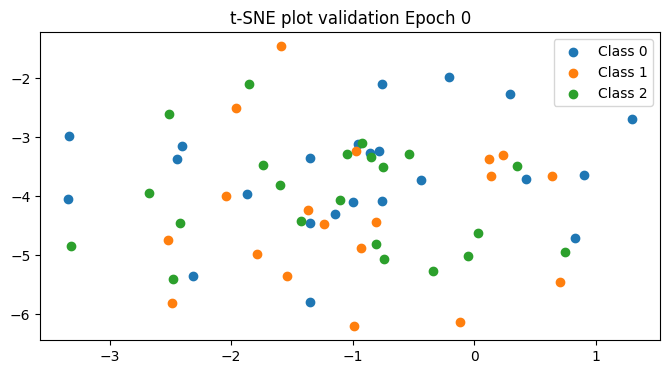

y_true shape: (64,)
y_pred shape: (64,)


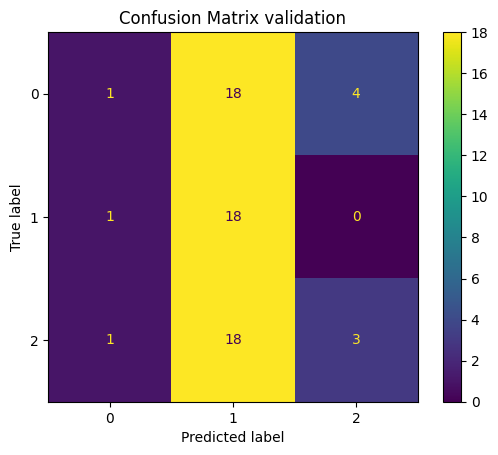

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6359384059906006
target_val/accuracy: 0.7368624806404114
target_val/f1: 0.7368133068084717
source_val/loss: 0.65724778175354
source_val/accuracy: 0.7262260317802429
source_val/f1: 0.7275105118751526
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


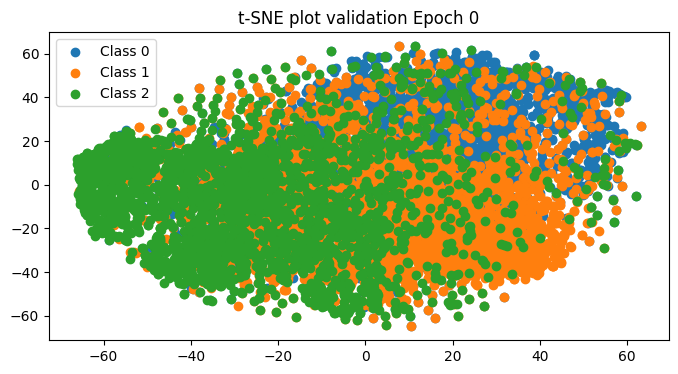

y_true shape: (7731,)
y_pred shape: (7731,)


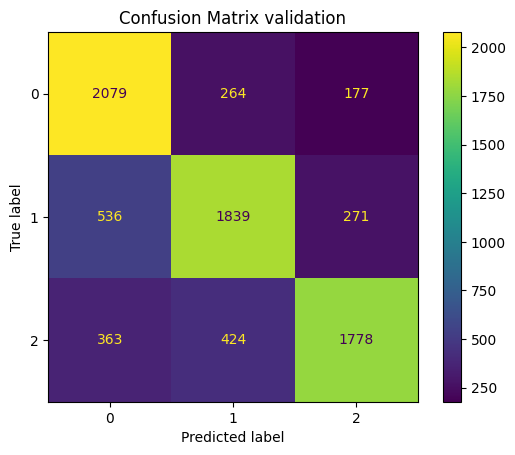

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.588620126247406
target_val/accuracy: 0.7612684369087219
target_val/f1: 0.761249840259552
source_val/loss: 0.6134742498397827
source_val/accuracy: 0.7487766146659851
source_val/f1: 0.7494646310806274
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


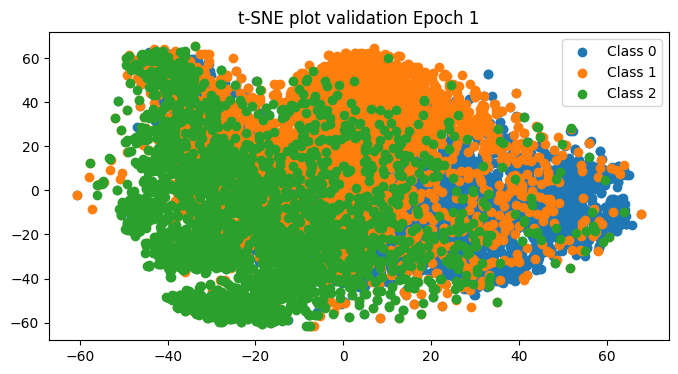

y_true shape: (7731,)
y_pred shape: (7731,)


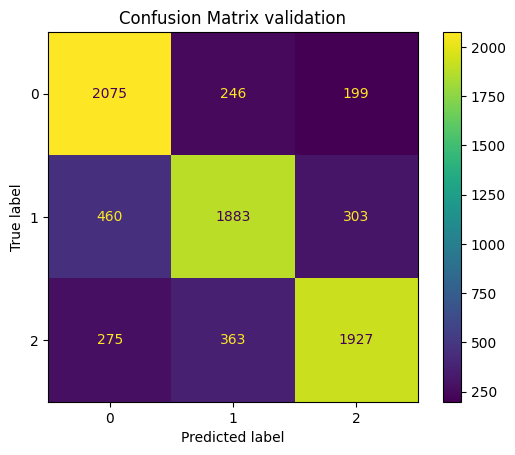

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.5888984203338623
target_val/accuracy: 0.7683707475662231
target_val/f1: 0.7682120203971863
source_val/loss: 0.6264732480049133
source_val/accuracy: 0.7544652223587036
source_val/f1: 0.7545290589332581
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


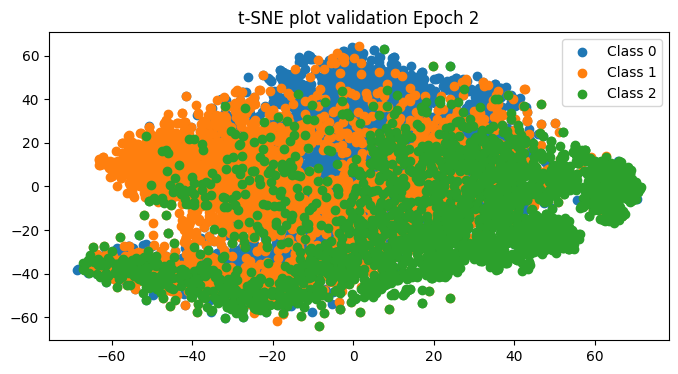

y_true shape: (7731,)
y_pred shape: (7731,)


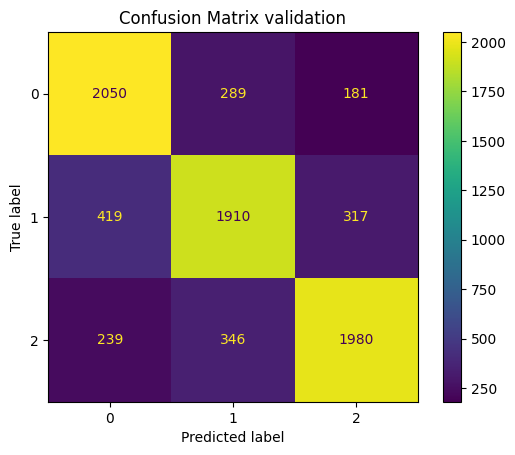

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6148794889450073
target_val/accuracy: 0.7674260139465332
target_val/f1: 0.7672280073165894
source_val/loss: 0.6639078855514526
source_val/accuracy: 0.7543361186981201
source_val/f1: 0.7546130418777466
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


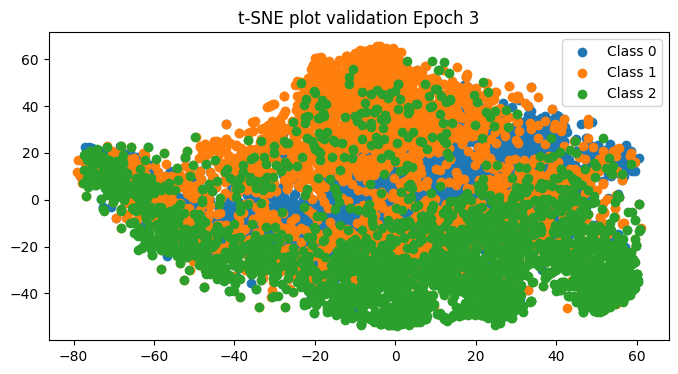

y_true shape: (7731,)
y_pred shape: (7731,)


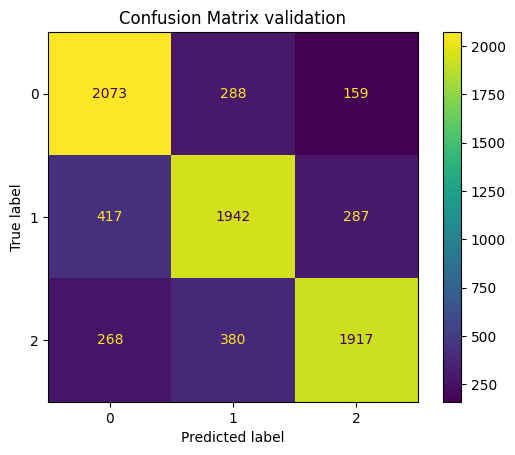

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6742457747459412
target_val/accuracy: 0.7610985040664673
target_val/f1: 0.7612258195877075
source_val/loss: 0.7214815020561218
source_val/accuracy: 0.7502039074897766
source_val/f1: 0.7509984374046326
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


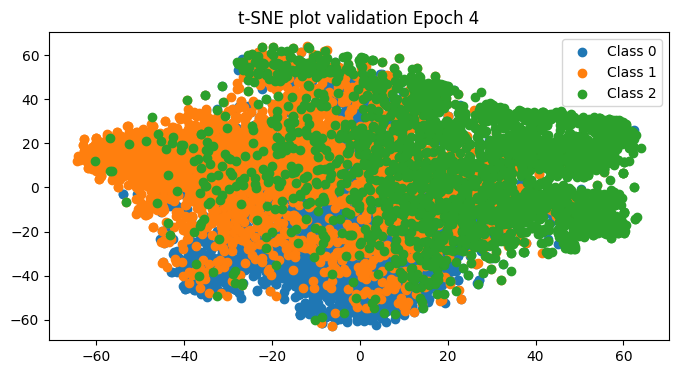

y_true shape: (7731,)
y_pred shape: (7731,)


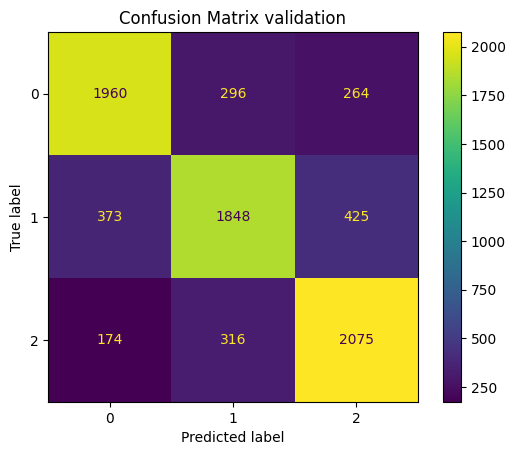

`Trainer.fit` stopped: `max_epochs=5` reached.


Best checkpoint path: checkpoints/lightning_logs/version_14/checkpoints/task-SF-epoch=01-val_loss=0.61.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_14/checkpoints/SF-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


prinssst: slate
print: fiction
print: 69613


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1955, 128, 768)
Labels shape: (1955,)
Flattened features shape: (1955, 98304)


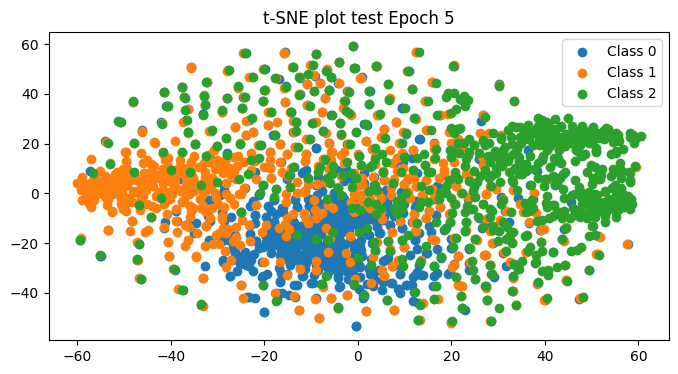

y_true shape: (1955,)
y_pred shape: (1955,)


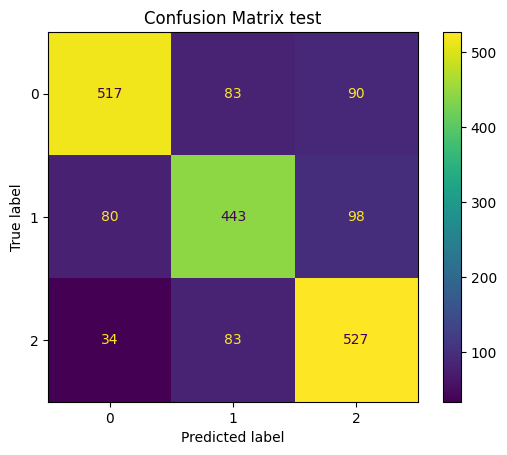

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7414314150810242     │
│      source_test/f1       │    0.7418776154518127     │
│   source_test/f1_macro    │    0.7298492789268494     │
│   source_test/f1_micro    │    0.7414314150810242     │
│     source_test/loss      │    0.7383726239204407     │
│   target_test/accuracy    │    0.7592405676841736     │
│      target_test/f1       │    0.7568560838699341     │
│   target_test/f1_macro    │     0.748465359210968     │
│   target_test/f1_micro    │    0.7592405676841736     │
│     target_test/loss      │    0.6931284070014954     │
└───────────────────────────┴───────────────────────────┘

Test Results Last Epoch: [{'source_test/loss': 0.7383726239204407, 'source_test/accuracy': 0.7414314150810242, 'source_test/f1': 0.7418776154518127, 'source_test/f1_macro': 0.7298492789268494, 'source_test/f1_micro': 0.7414314150810242, 'target_test/loss': 0.6931284070014954, 'target_test/accuracy': 0.7592405676841736, 'target_test/f1': 0.7568560838699341, 'target_test/f1_macro': 0.748465359210968, 'target_test/f1_micro': 0.7592405676841736}]
Best checkpoint path: checkpoints/lightning_logs/version_14/checkpoints/task-SF-epoch=01-val_loss=0.61.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_14/checkpoints/SF-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1955, 128, 768)
Labels shape: (1955,)
Flattened features shape: (1955, 98304)


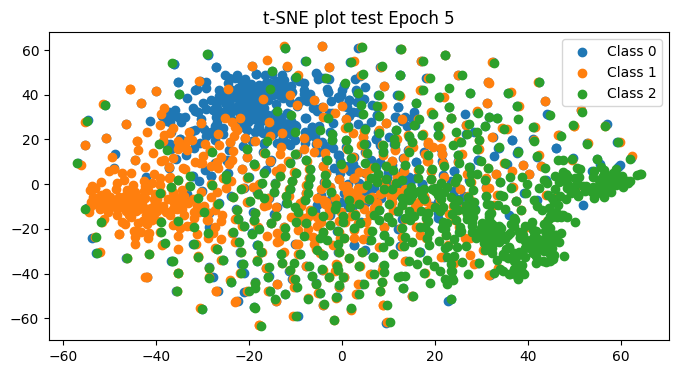

y_true shape: (1955,)
y_pred shape: (1955,)


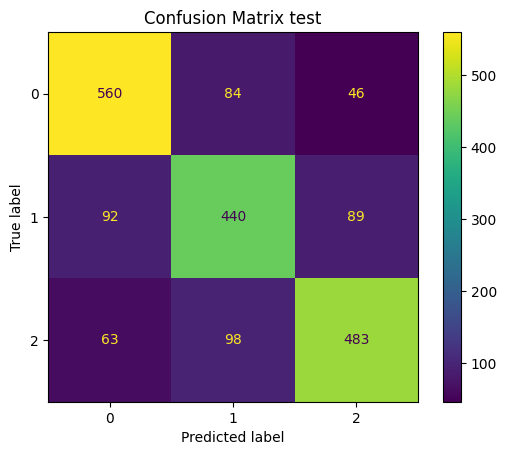

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7358870506286621     │
│      source_test/f1       │    0.7376258373260498     │
│   source_test/f1_macro    │    0.7241599559783936     │
│   source_test/f1_micro    │    0.7358870506286621     │
│     source_test/loss      │     0.644640326499939     │
│   target_test/accuracy    │     0.757224440574646     │
│      target_test/f1       │    0.7555580139160156     │
│   target_test/f1_macro    │    0.7436427474021912     │
│   target_test/f1_micro    │     0.757224440574646     │
│     target_test/loss      │    0.5878745317459106     │
└───────────────────────────┴───────────────────────────┘

Test Results on Best Model: [{'source_test/loss': 0.644640326499939, 'source_test/accuracy': 0.7358870506286621, 'source_test/f1': 0.7376258373260498, 'source_test/f1_macro': 0.7241599559783936, 'source_test/f1_micro': 0.7358870506286621, 'target_test/loss': 0.5878745317459106, 'target_test/accuracy': 0.757224440574646, 'target_test/f1': 0.7555580139160156, 'target_test/f1_macro': 0.7436427474021912, 'target_test/f1_micro': 0.757224440574646}]


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1955, 128, 768)
Labels shape: (1955,)
Flattened features shape: (1955, 98304)


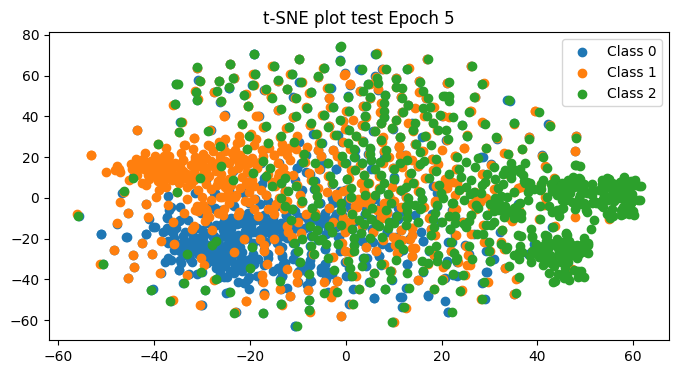

y_true shape: (1955,)
y_pred shape: (1955,)


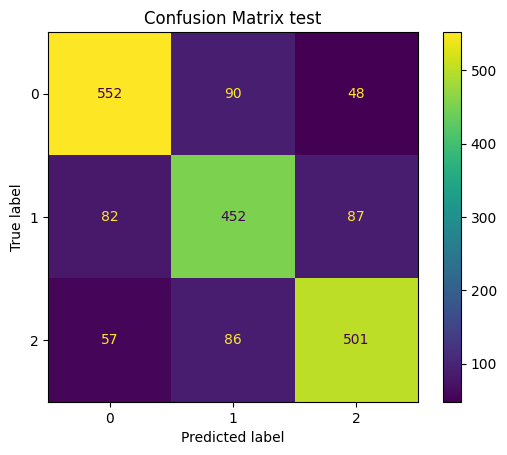

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7479838728904724     │
│      source_test/f1       │    0.7479904890060425     │
│   source_test/f1_macro    │    0.7374513745307922     │
│   source_test/f1_micro    │    0.7479838728904724     │
│     source_test/loss      │    0.6508790254592896     │
│   target_test/accuracy    │    0.7683131694793701     │
│      target_test/f1       │    0.7664896845817566     │
│   target_test/f1_macro    │    0.7562741041183472     │
│   target_test/f1_micro    │    0.7683131694793701     │
│     target_test/loss      │    0.5874096155166626     │
└───────────────────────────┴───────────────────────────┘

Seed set to 10


Test Results on saved epoch: [{'source_test/loss': 0.6508790254592896, 'source_test/accuracy': 0.7479838728904724, 'source_test/f1': 0.7479904890060425, 'source_test/f1_macro': 0.7374513745307922, 'source_test/f1_micro': 0.7479838728904724, 'target_test/loss': 0.5874096155166626, 'target_test/accuracy': 0.7683131694793701, 'target_test/f1': 0.7664896845817566, 'target_test/f1_macro': 0.7562741041183472, 'target_test/f1_micro': 0.7683131694793701}]


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


prinssst: slate
print: fiction
print: 69613
prinssst: slate
print: fiction
print: 69613


Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 1.112105131149292
target_val/accuracy: 0.265625
target_val/f1: 0.35850805044174194
source_val/loss: 1.1079206466674805
source_val/accuracy: 0.28125
source_val/f1: 0.4184451103210449
Features shape: (64, 128, 768)
Labels shape: (64,)
Flattened features shape: (64, 98304)


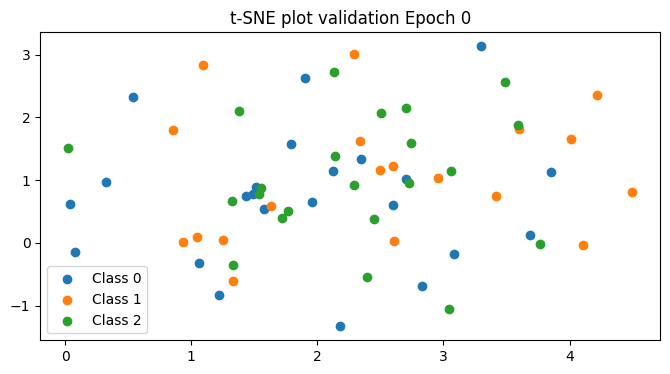

y_true shape: (64,)
y_pred shape: (64,)


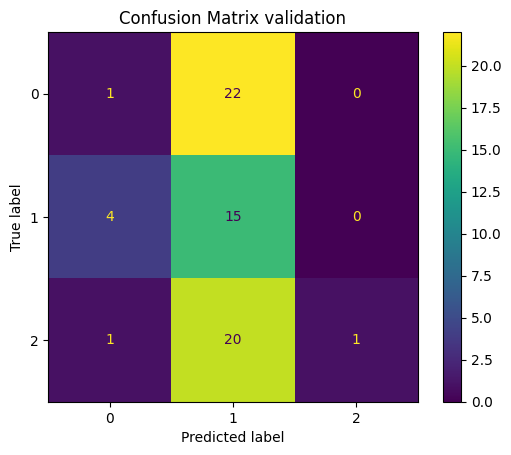

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6258298754692078
target_val/accuracy: 0.7396557927131653
target_val/f1: 0.740751326084137
source_val/loss: 0.6482418775558472
source_val/accuracy: 0.7296242713928223
source_val/f1: 0.731261670589447
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


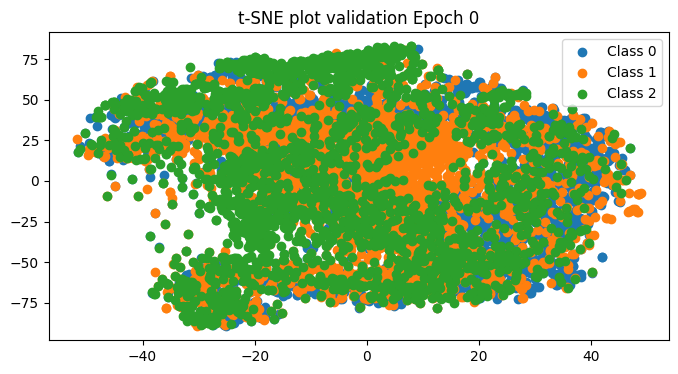

y_true shape: (7731,)
y_pred shape: (7731,)


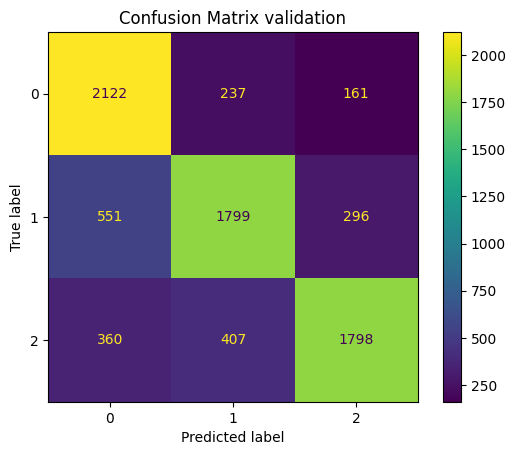

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.5789628028869629
target_val/accuracy: 0.7635928392410278
target_val/f1: 0.7640001177787781
source_val/loss: 0.6093711853027344
source_val/accuracy: 0.7552332282066345
source_val/f1: 0.7557506561279297
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


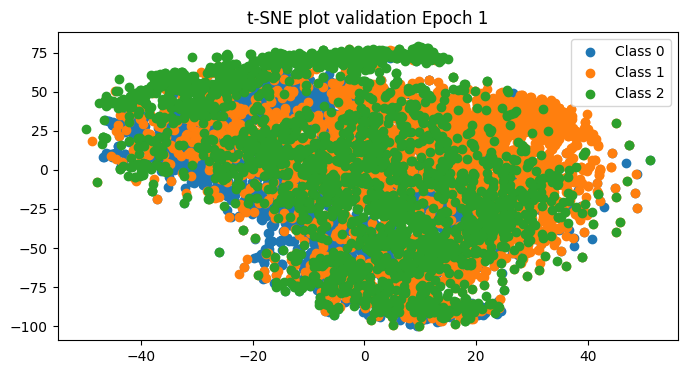

y_true shape: (7731,)
y_pred shape: (7731,)


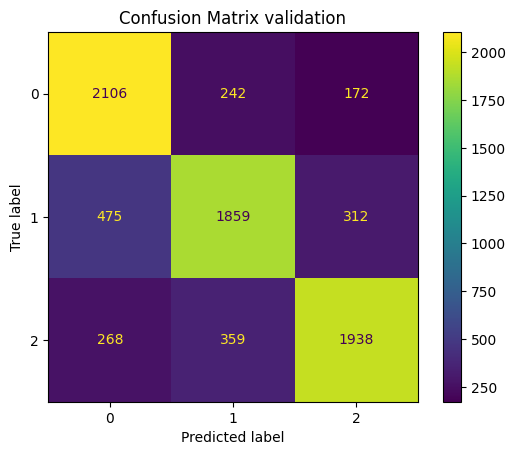

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.5807462334632874
target_val/accuracy: 0.7681124806404114
target_val/f1: 0.7679429650306702
source_val/loss: 0.6177938580513
source_val/accuracy: 0.760099470615387
source_val/f1: 0.7604231834411621
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


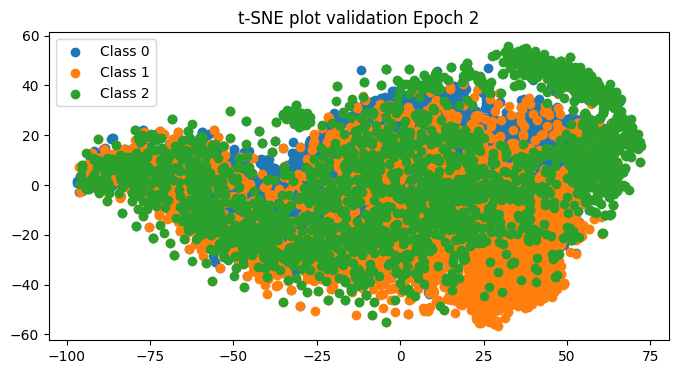

y_true shape: (7731,)
y_pred shape: (7731,)


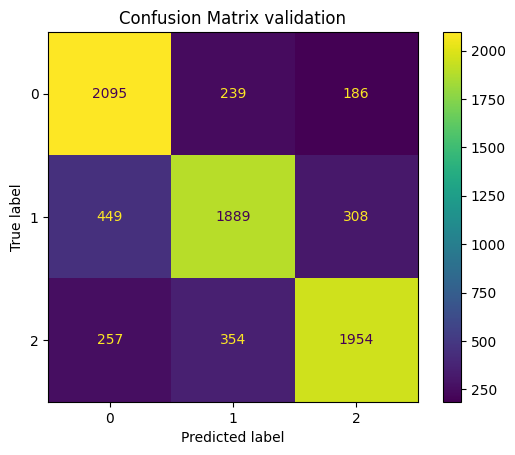

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6162441372871399
target_val/accuracy: 0.7617849707603455
target_val/f1: 0.7614750862121582
source_val/loss: 0.6267589926719666
source_val/accuracy: 0.7599703073501587
source_val/f1: 0.7600789666175842
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


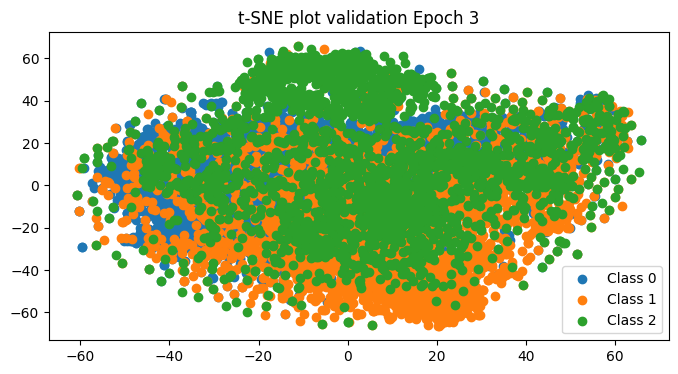

y_true shape: (7731,)
y_pred shape: (7731,)


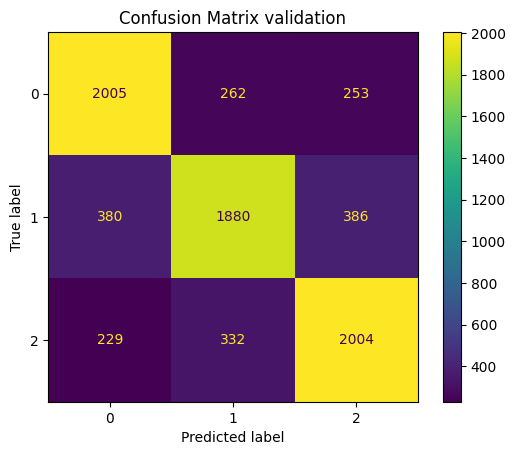

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6502084732055664
target_val/accuracy: 0.7639802098274231
target_val/f1: 0.7639610171318054
source_val/loss: 0.6748929619789124
source_val/accuracy: 0.7611801028251648
source_val/f1: 0.7623999118804932
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


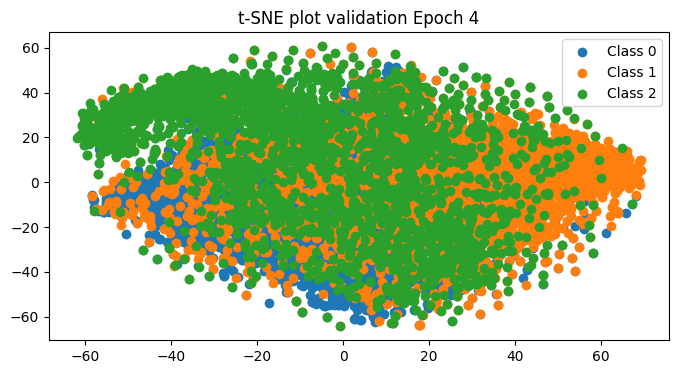

y_true shape: (7731,)
y_pred shape: (7731,)


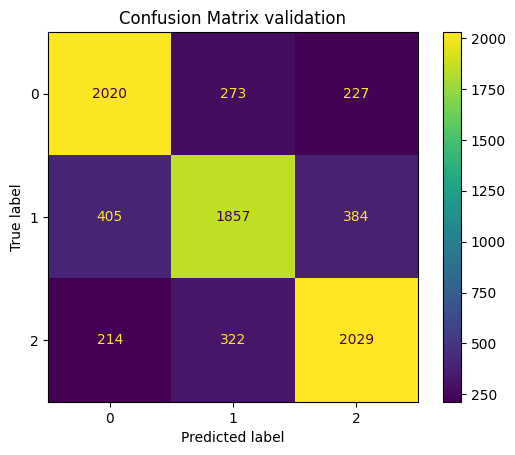

`Trainer.fit` stopped: `max_epochs=5` reached.


Best checkpoint path: checkpoints/lightning_logs/version_15/checkpoints/task-SF-epoch=01-val_loss=0.61.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_15/checkpoints/SF-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


prinssst: slate
print: fiction
print: 69613


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1955, 128, 768)
Labels shape: (1955,)
Flattened features shape: (1955, 98304)


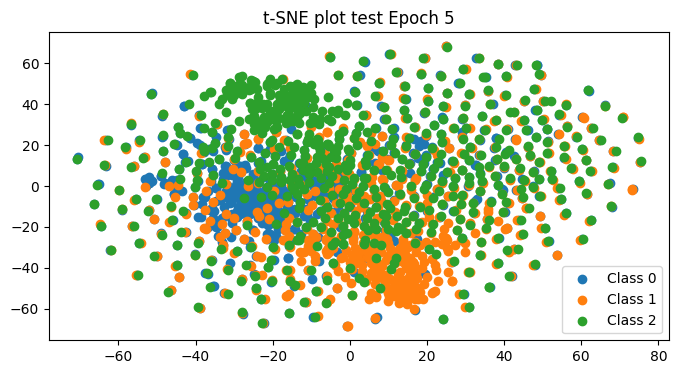

y_true shape: (1955,)
y_pred shape: (1955,)


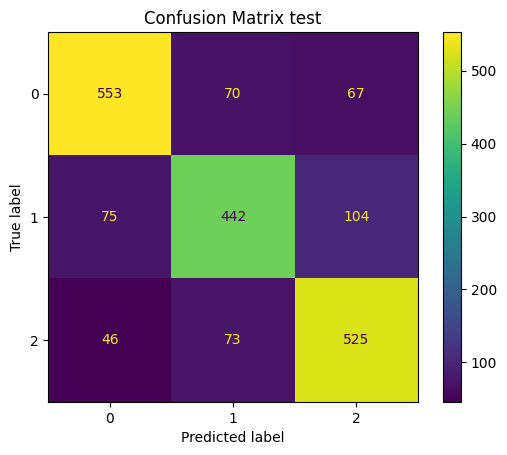

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7474797964096069     │
│      source_test/f1       │    0.7478328347206116     │
│   source_test/f1_macro    │    0.7357730269432068     │
│   source_test/f1_micro    │    0.7474797964096069     │
│     source_test/loss      │    0.6942046284675598     │
│   target_test/accuracy    │    0.7807459235191345     │
│      target_test/f1       │    0.7817371487617493     │
│   target_test/f1_macro    │    0.7697430849075317     │
│   target_test/f1_micro    │    0.7807459235191345     │
│     target_test/loss      │    0.6371800899505615     │
└───────────────────────────┴───────────────────────────┘

Test Results Last Epoch: [{'source_test/loss': 0.6942046284675598, 'source_test/accuracy': 0.7474797964096069, 'source_test/f1': 0.7478328347206116, 'source_test/f1_macro': 0.7357730269432068, 'source_test/f1_micro': 0.7474797964096069, 'target_test/loss': 0.6371800899505615, 'target_test/accuracy': 0.7807459235191345, 'target_test/f1': 0.7817371487617493, 'target_test/f1_macro': 0.7697430849075317, 'target_test/f1_micro': 0.7807459235191345}]
Best checkpoint path: checkpoints/lightning_logs/version_15/checkpoints/task-SF-epoch=01-val_loss=0.61.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_15/checkpoints/SF-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1955, 128, 768)
Labels shape: (1955,)
Flattened features shape: (1955, 98304)


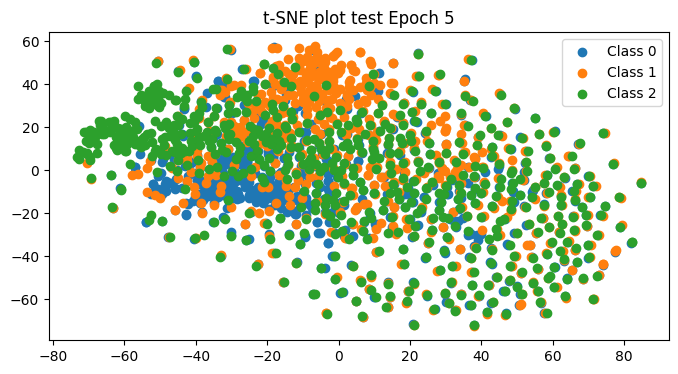

y_true shape: (1955,)
y_pred shape: (1955,)


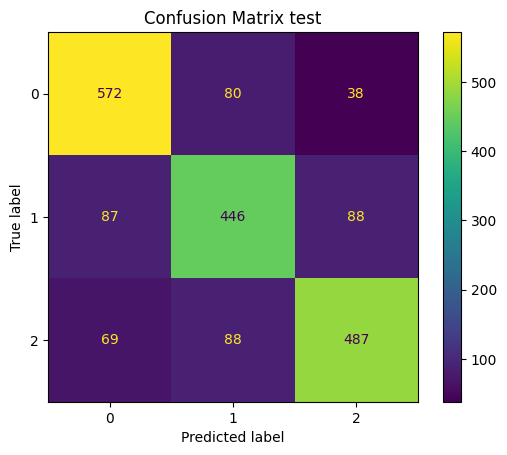

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7399193048477173     │
│      source_test/f1       │     0.741291880607605     │
│   source_test/f1_macro    │    0.7254903316497803     │
│   source_test/f1_micro    │    0.7399193048477173     │
│     source_test/loss      │    0.6303182244300842     │
│   target_test/accuracy    │    0.7634409070014954     │
│      target_test/f1       │    0.7640317678451538     │
│   target_test/f1_macro    │    0.7524001598358154     │
│   target_test/f1_micro    │    0.7634409070014954     │
│     target_test/loss      │    0.5757207274436951     │
└───────────────────────────┴───────────────────────────┘

Test Results on Best Model: [{'source_test/loss': 0.6303182244300842, 'source_test/accuracy': 0.7399193048477173, 'source_test/f1': 0.741291880607605, 'source_test/f1_macro': 0.7254903316497803, 'source_test/f1_micro': 0.7399193048477173, 'target_test/loss': 0.5757207274436951, 'target_test/accuracy': 0.7634409070014954, 'target_test/f1': 0.7640317678451538, 'target_test/f1_macro': 0.7524001598358154, 'target_test/f1_micro': 0.7634409070014954}]


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1955, 128, 768)
Labels shape: (1955,)
Flattened features shape: (1955, 98304)


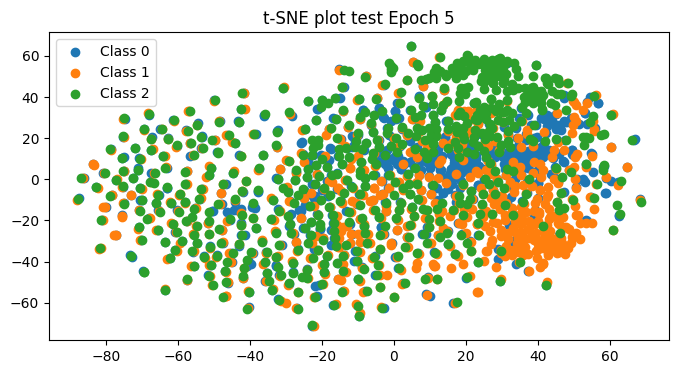

y_true shape: (1955,)
y_pred shape: (1955,)


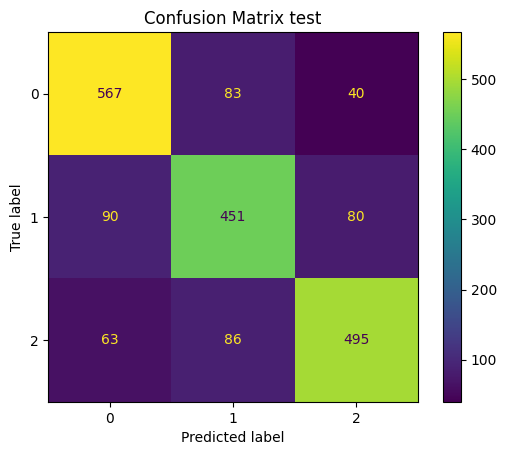

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7459677457809448     │
│      source_test/f1       │    0.7470871806144714     │
│   source_test/f1_macro    │     0.734624981880188     │
│   source_test/f1_micro    │    0.7459677457809448     │
│     source_test/loss      │    0.6439879536628723     │
│   target_test/accuracy    │    0.7723454236984253     │
│      target_test/f1       │     0.772576093673706     │
│   target_test/f1_macro    │    0.7617526650428772     │
│   target_test/f1_micro    │    0.7723454236984253     │
│     target_test/loss      │    0.5791292190551758     │
└───────────────────────────┴───────────────────────────┘

Seed set to 100


Test Results on saved epoch: [{'source_test/loss': 0.6439879536628723, 'source_test/accuracy': 0.7459677457809448, 'source_test/f1': 0.7470871806144714, 'source_test/f1_macro': 0.734624981880188, 'source_test/f1_micro': 0.7459677457809448, 'target_test/loss': 0.5791292190551758, 'target_test/accuracy': 0.7723454236984253, 'target_test/f1': 0.772576093673706, 'target_test/f1_macro': 0.7617526650428772, 'target_test/f1_micro': 0.7723454236984253}]


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


prinssst: slate
print: fiction
print: 69613
prinssst: slate
print: fiction
print: 69613


Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configu

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | BertAdapterModel   | 118 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
3 | f1        | MulticlassF1Score  | 0     
4 | f1_macro  | MulticlassF1Score  | 0     
5 | f1_micro  | MulticlassF1Score  | 0     
6 | softmax   | Softmax            | 0     
-------------------------------------------------
8.9 M     Trainable params
109 M     Non-trainable params
118 M     Total params
473.522   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 1.1084132194519043
target_val/accuracy: 0.21875
target_val/f1: 0.2276785671710968
source_val/loss: 1.103001594543457
source_val/accuracy: 0.265625
source_val/f1: 0.29009944200515747
Features shape: (64, 128, 768)
Labels shape: (64,)
Flattened features shape: (64, 98304)


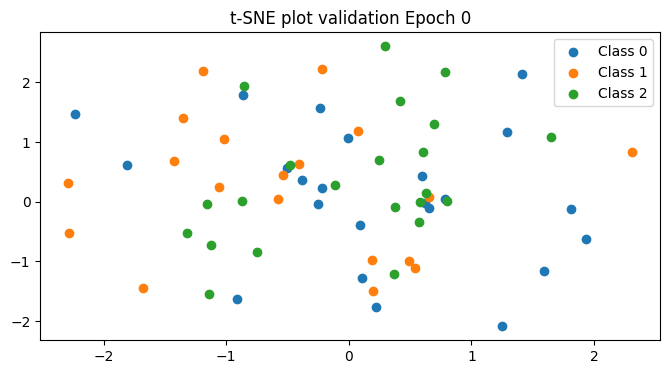

y_true shape: (64,)
y_pred shape: (64,)


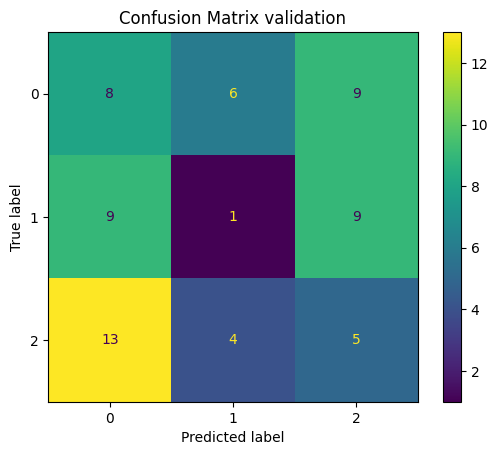

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6353561282157898
target_val/accuracy: 0.733674943447113
target_val/f1: 0.7339692711830139
source_val/loss: 0.6578093767166138
source_val/accuracy: 0.7241598963737488
source_val/f1: 0.7260181903839111
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


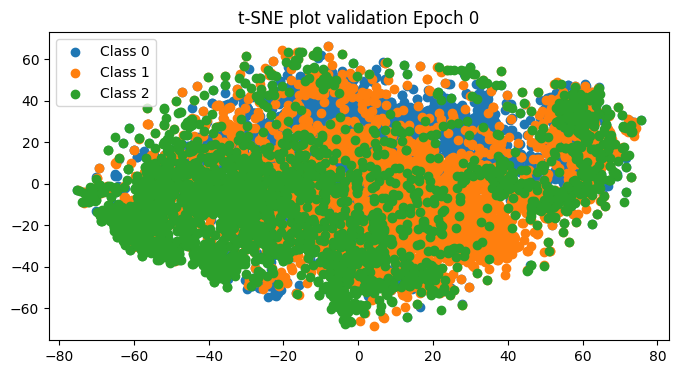

y_true shape: (7731,)
y_pred shape: (7731,)


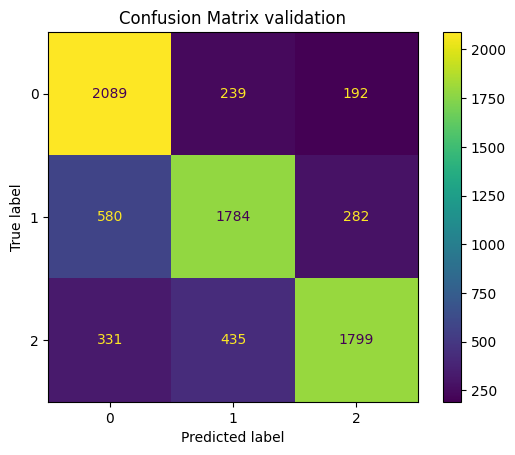

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.5717859864234924
target_val/accuracy: 0.7650132775306702
target_val/f1: 0.7646290063858032
source_val/loss: 0.6032634377479553
source_val/accuracy: 0.7503737211227417
source_val/f1: 0.7515674829483032
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


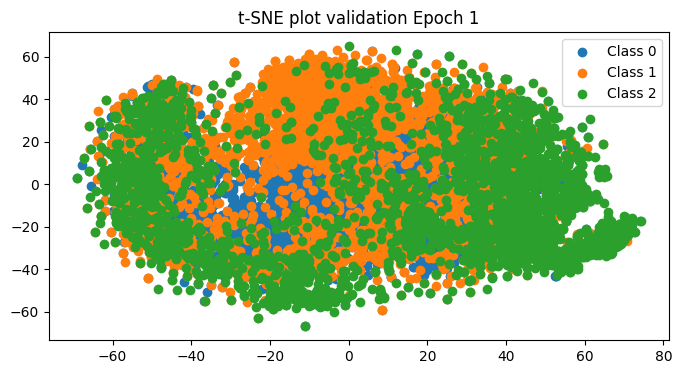

y_true shape: (7731,)
y_pred shape: (7731,)


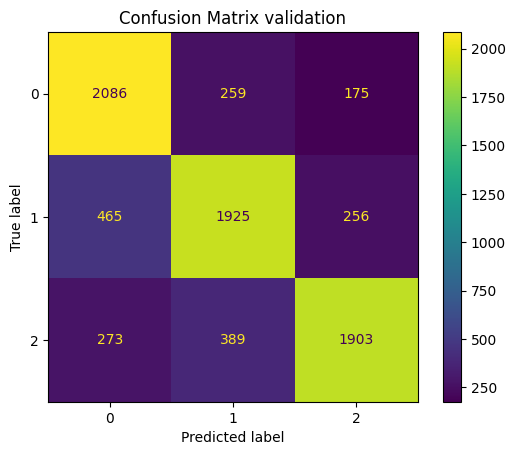

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.5749374032020569
target_val/accuracy: 0.7684998512268066
target_val/f1: 0.7686125040054321
source_val/loss: 0.6085296869277954
source_val/accuracy: 0.7623423337936401
source_val/f1: 0.7631601691246033
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


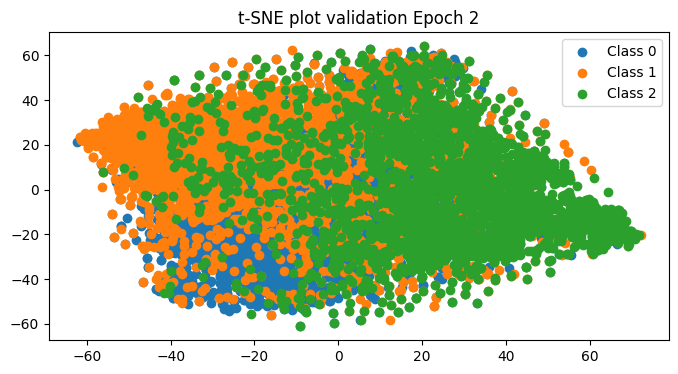

y_true shape: (7731,)
y_pred shape: (7731,)


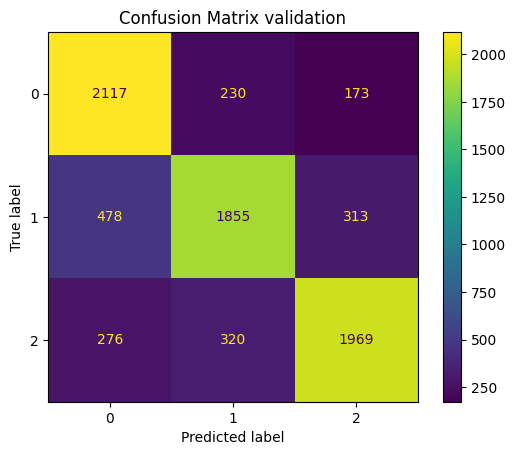

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6072431206703186
target_val/accuracy: 0.7669094800949097
target_val/f1: 0.7665635943412781
source_val/loss: 0.6354497075080872
source_val/accuracy: 0.7584683299064636
source_val/f1: 0.7593023180961609
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


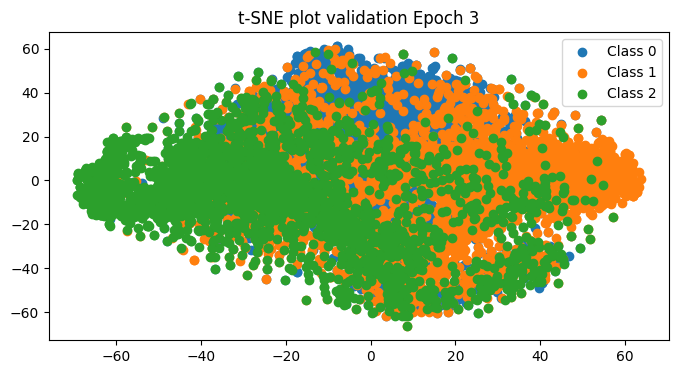

y_true shape: (7731,)
y_pred shape: (7731,)


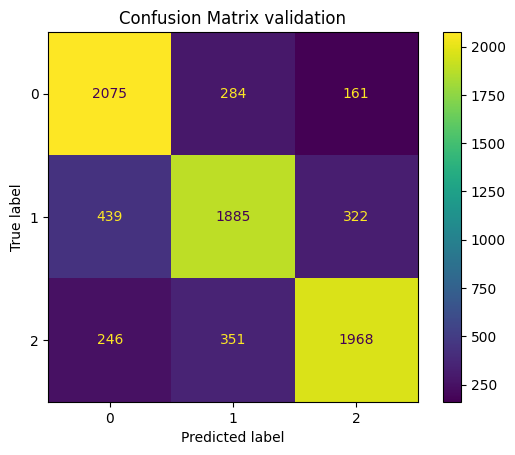

/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: |          | 0/? [00:00<?, ?it/s]

target_val/loss: 0.6577614545822144
target_val/accuracy: 0.7715582251548767
target_val/f1: 0.7720217704772949
source_val/loss: 0.6903889775276184
source_val/accuracy: 0.7564429640769958
source_val/f1: 0.7581746578216553
Features shape: (7731, 128, 768)
Labels shape: (7731,)
Flattened features shape: (7731, 98304)


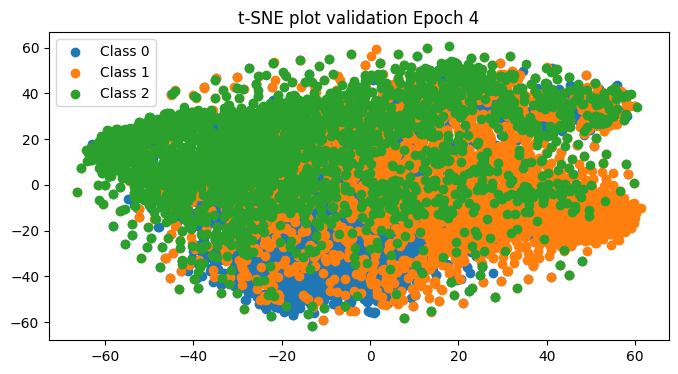

y_true shape: (7731,)
y_pred shape: (7731,)


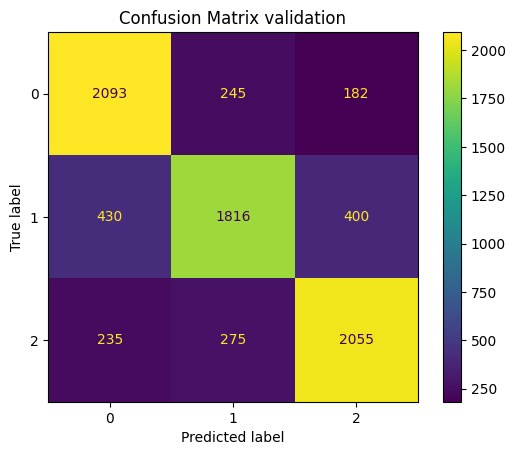

`Trainer.fit` stopped: `max_epochs=5` reached.


Best checkpoint path: checkpoints/lightning_logs/version_16/checkpoints/task-SF-epoch=01-val_loss=0.60.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_16/checkpoints/SF-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


prinssst: slate
print: fiction
print: 69613


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1955, 128, 768)
Labels shape: (1955,)
Flattened features shape: (1955, 98304)


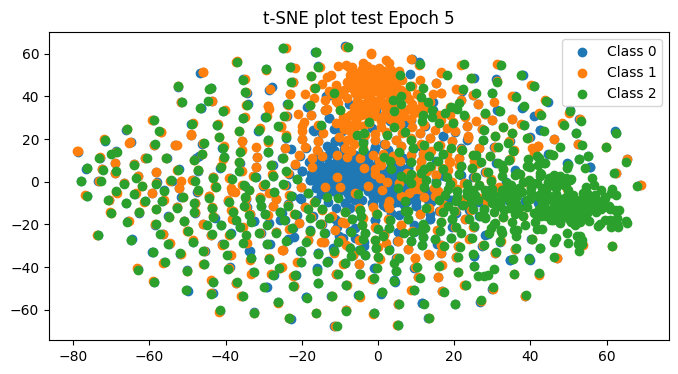

y_true shape: (1955,)
y_pred shape: (1955,)


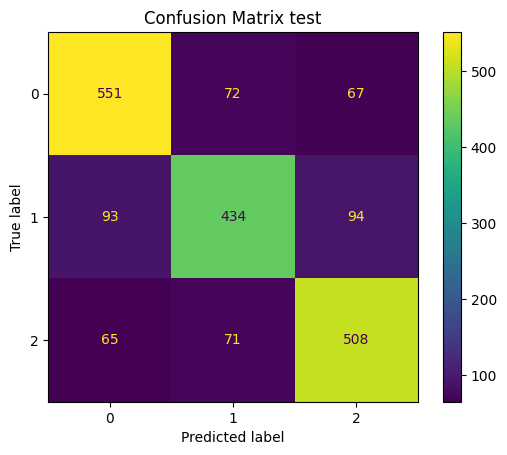

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7515120506286621     │
│      source_test/f1       │    0.7525180578231812     │
│   source_test/f1_macro    │    0.7387466430664062     │
│   source_test/f1_micro    │    0.7515120506286621     │
│     source_test/loss      │    0.7263600826263428     │
│   target_test/accuracy    │    0.7671370506286621     │
│      target_test/f1       │     0.76791912317276      │
│   target_test/f1_macro    │    0.7556726932525635     │
│   target_test/f1_micro    │    0.7671370506286621     │
│     target_test/loss      │     0.665591299533844     │
└───────────────────────────┴───────────────────────────┘

Test Results Last Epoch: [{'source_test/loss': 0.7263600826263428, 'source_test/accuracy': 0.7515120506286621, 'source_test/f1': 0.7525180578231812, 'source_test/f1_macro': 0.7387466430664062, 'source_test/f1_micro': 0.7515120506286621, 'target_test/loss': 0.665591299533844, 'target_test/accuracy': 0.7671370506286621, 'target_test/f1': 0.76791912317276, 'target_test/f1_macro': 0.7556726932525635, 'target_test/f1_micro': 0.7671370506286621}]
Best checkpoint path: checkpoints/lightning_logs/version_16/checkpoints/task-SF-epoch=01-val_loss=0.60.ckpt
Saved epoch checkpoint path: checkpoints/lightning_logs/version_16/checkpoints/SF-epoch=02.ckpt


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1955, 128, 768)
Labels shape: (1955,)
Flattened features shape: (1955, 98304)


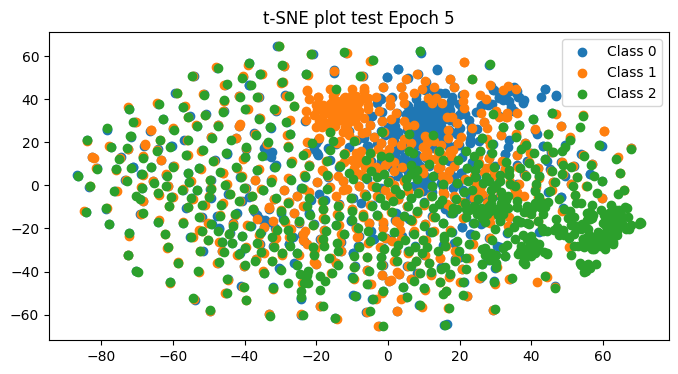

y_true shape: (1955,)
y_pred shape: (1955,)


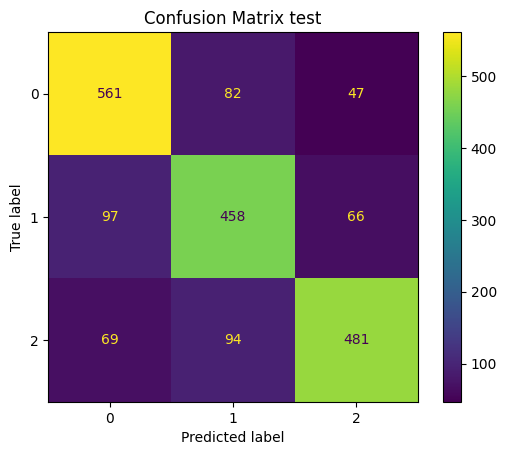

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7489919066429138     │
│      source_test/f1       │     0.750303328037262     │
│   source_test/f1_macro    │    0.7383006811141968     │
│   source_test/f1_micro    │    0.7489919066429138     │
│     source_test/loss      │    0.6230837106704712     │
│   target_test/accuracy    │    0.7657930254936218     │
│      target_test/f1       │    0.7638534903526306     │
│   target_test/f1_macro    │    0.7548571825027466     │
│   target_test/f1_micro    │    0.7657930254936218     │
│     target_test/loss      │    0.5751375555992126     │
└───────────────────────────┴───────────────────────────┘

Test Results on Best Model: [{'source_test/loss': 0.6230837106704712, 'source_test/accuracy': 0.7489919066429138, 'source_test/f1': 0.750303328037262, 'source_test/f1_macro': 0.7383006811141968, 'source_test/f1_micro': 0.7489919066429138, 'target_test/loss': 0.5751375555992126, 'target_test/accuracy': 0.7657930254936218, 'target_test/f1': 0.7638534903526306, 'target_test/f1_macro': 0.7548571825027466, 'target_test/f1_micro': 0.7657930254936218}]


/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
mlm_union_F              union             7,682,688       7.017       1       1
--------------------------------------------------------------------------------
Full model                               109,482,240     100.000               0
trainable params: 8898237 || all params: 118380477 || trainable%: 7.5166422922928415
None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/guest/.cache/pypoetry/virtualenvs/fourth-experments-OVNdUUAn-py3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

Features shape: (1955, 128, 768)
Labels shape: (1955,)
Flattened features shape: (1955, 98304)


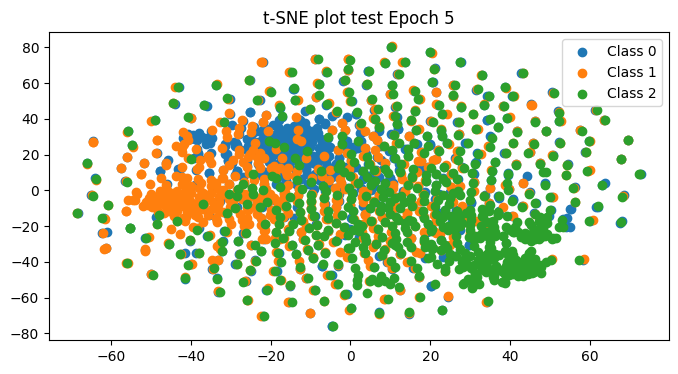

y_true shape: (1955,)
y_pred shape: (1955,)


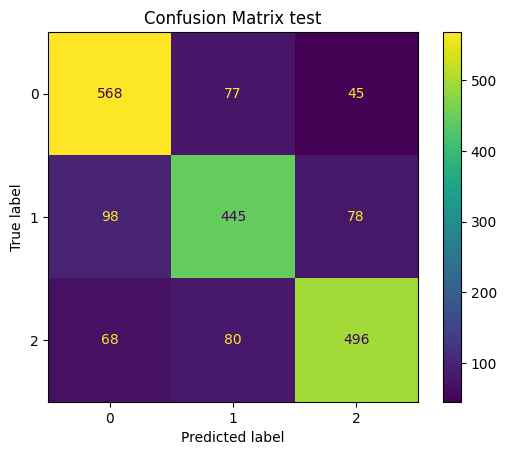

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   source_test/accuracy    │    0.7505040168762207     │
│      source_test/f1       │    0.7528020739555359     │
│   source_test/f1_macro    │    0.7386470437049866     │
│   source_test/f1_micro    │    0.7505040168762207     │
│     source_test/loss      │    0.6319759488105774     │
│   target_test/accuracy    │     0.765457034111023     │
│      target_test/f1       │    0.7658218145370483     │
│   target_test/f1_macro    │    0.7555373907089233     │
│   target_test/f1_micro    │     0.765457034111023     │
│     target_test/loss      │    0.5850667953491211     │
└───────────────────────────┴───────────────────────────┘

Test Results on saved epoch: [{'source_test/loss': 0.6319759488105774, 'source_test/accuracy': 0.7505040168762207, 'source_test/f1': 0.7528020739555359, 'source_test/f1_macro': 0.7386470437049866, 'source_test/f1_micro': 0.7505040168762207, 'target_test/loss': 0.5850667953491211, 'target_test/accuracy': 0.765457034111023, 'target_test/f1': 0.7658218145370483, 'target_test/f1_macro': 0.7555373907089233, 'target_test/f1_micro': 0.765457034111023}]


In [7]:
for seed in seeds:
    #wandb.init(project=project_name, name=f'{domain}_{type}_run_with_seed_{seed}', config={'seed': seed})

    try:
        seed_everything(seed)

        hparams = {
            "source_target": "slate_fiction",
            "source_domain": "slate",
            "target_domain": "fiction",
            "domain_adapter_name": "mlm_union_F",
            "task_adapter_name": "task_SF",
            "pretrained_model_name": "bert-base-uncased",
            "padding": "max_length",
            "max_seq_length": 128,
            "bsz": 32,
            "num_classes": 3,
            "learning_rate": 1e-4,
            "reduction_factor": 16,
            "mode": "domain",
            "saved_adapter_dir": "../../saved/adapters",
        }

        save_dir = "checkpoints"
        save_epoch_3 = 3  # Save model at the 3rd epoch
        #save_model_callback_epoch = SaveModelAtEpochCallback(save_dir, save_epoch_3)
        # Add a print statement to confirm the callback initialization
        #print(f"Initialized SaveModelAtEpochCallback with save_dir={save_dir} and save_epoch={save_epoch_3}")
        dm = processed.DataModuleSourceTarget(hparams)
        dm.setup('fit')
        dm.setup("test")

        model = DomainTaskAdapter(hparams)

        checkpoint_callback = ModelCheckpoint(
            filename="task-SF-{epoch:02d}-{val_loss:.2f}",
            save_top_k=1,
            monitor="val_loss",
            mode="min",
        )
        save_model_callback_epoch = ModelCheckpoint(
                # dirpath=checkpoints_path, # <--- specify this on the trainer itself for version control
                filename="SF-{epoch:02d}",
                every_n_epochs=save_epoch_3,
                save_top_k=-1,  # <--- this is important!
            )
       
        #wandb_logger = WandbLogger()
        
    except Exception as e:
        print(f"Error during preprocessing : {e}")   

    try:
        train_loader = dm.train_dataloader()
        val_loader = dm.val_dataloader()
        trainer = Trainer(
            max_epochs=5,
            accelerator="auto",
            default_root_dir="checkpoints",
            # precision=16,
            #logger=wandb_logger,
            callbacks=[checkpoint_callback,save_model_callback_epoch],
            limit_train_batches=1.0,
            limit_val_batches=1.0,
            limit_test_batches=1.0,
            # log_every_n_TESps=10,
        )
      
        trainer.fit(model, train_loader, val_loader)
           # ATESr training, print the paths to verify
        print(f"Best checkpoint path: {checkpoint_callback.best_model_path}")
        print(f"Saved epoch checkpoint path: {save_model_callback_epoch.best_model_path}")
    except Exception as e:
        print(f"Error during training : {e}")

    try:
        
        dm.setup("test")
        test_loader = dm.test_dataloader()
        test_results_last = trainer.test(model, test_loader)
        print("Test Results Last Epoch:", test_results_last)

        # Collect results for last epoch model
        for key, value in test_results_last[0].items():
            results["last_epoch"][key].append(value)

        # Paths to the saved checkpoints
        best_checkpoint_path = checkpoint_callback.best_model_path
        saved_epoch_checkpoint_path = save_model_callback_epoch.best_model_path
        # Print the paths to verify
        print(f"Best checkpoint path: {best_checkpoint_path}")
        print(f"Saved epoch checkpoint path: {saved_epoch_checkpoint_path}")
        
        best_model = DomainTaskAdapter.load_from_checkpoint(best_checkpoint_path)
        test_results_best = trainer.test(best_model, test_loader)
        print("Test Results on Best Model:", test_results_best)
        # Collect results for best model
        for key, value in test_results_best[0].items():
            results["best_model"][key].append(value)

        saved_epoch_model = DomainTaskAdapter.load_from_checkpoint(saved_epoch_checkpoint_path)
        test_results_saved_epoch = trainer.test(saved_epoch_model, test_loader)
        print("Test Results on saved epoch:", test_results_saved_epoch)
        # Collect results for 3rd epoch model
        for key, value in test_results_saved_epoch[0].items():
            results["epoch_saved"][key].append(value)
        

    except Exception as e:
        print(f"Error during testing: {e}")

    # Finish the wandb run
    #wandb.finish()

In [8]:
results.items()

dict_items([('last_epoch', {'source_test/loss': [0.7383726239204407, 0.6942046284675598, 0.7263600826263428], 'source_test/accuracy': [0.7414314150810242, 0.7474797964096069, 0.7515120506286621], 'source_test/f1': [0.7418776154518127, 0.7478328347206116, 0.7525180578231812], 'source_test/f1_macro': [0.7298492789268494, 0.7357730269432068, 0.7387466430664062], 'source_test/f1_micro': [0.7414314150810242, 0.7474797964096069, 0.7515120506286621], 'target_test/loss': [0.6931284070014954, 0.6371800899505615, 0.665591299533844], 'target_test/accuracy': [0.7592405676841736, 0.7807459235191345, 0.7671370506286621], 'target_test/f1': [0.7568560838699341, 0.7817371487617493, 0.76791912317276], 'target_test/f1_macro': [0.748465359210968, 0.7697430849075317, 0.7556726932525635], 'target_test/f1_micro': [0.7592405676841736, 0.7807459235191345, 0.7671370506286621]}), ('best_model', {'source_test/loss': [0.644640326499939, 0.6303182244300842, 0.6230837106704712], 'source_test/accuracy': [0.7358870506

| Scenario   | Metric                   | Mean     | Std      |
|------------|--------------------------|----------|----------|
| Saved Epoch| Source Test Accuracy     | 0.79453  | 0.00078  |
|            | Source Test F1           | 0.79384  | 0.00038  |
|            | Source Test F1 Macro     | 0.78626  | 0.00084  |
|            | Source Test F1 Micro     | 0.79453  | 0.00078  |
|            | Target Test Accuracy     | 0.74798  | 0.00329  |
|            | Target Test F1           | 0.74773  | 0.00318  |
|            | Target Test F1 Macro     | 0.73880  | 0.00362  |
|            | Target Test F1 Micro     | 0.74798  | 0.00329  |
| Best Model | Source Test Accuracy     | 0.79038  | 0.00394  |
|            | Source Test F1           | 0.78934  | 0.00389  |
|            | Source Test F1 Macro     | 0.78119  | 0.00237  |
|            | Source Test F1 Micro     | 0.79038  | 0.00394  |
|            | Target Test Accuracy     | 0.74736  | 0.00237  |
|            | Target Test F1           | 0.74587  | 0.00238  |
|            | Target Test F1 Macro     | 0.73849  | 0.00257  |
|            | Target Test F1 Micro     | 0.74736  | 0.00237  |
| Last Epoch | Source Test Accuracy     | 0.79366  | 0.00178  |
|            | Source Test F1           | 0.79381  | 0.00110  |
|            | Source Test F1 Macro     | 0.78581  | 0.00289  |
|            | Source Test F1 Micro     | 0.79366  | 0.00178  |
|            | Target Test Accuracy     | 0.74942  | 0.00662  |
|            | Target Test F1           | 0.74830  | 0.00757  |
|            | Target Test F1 Macro     | 0.74064  | 0.00640  |
|            | Target Test F1 Micro     | 0.74942  | 0.00662  |


In [9]:
# Calculate mean and standard deviation for each scenario
mean_results = {scenario: {key: np.mean(values) for key, values in metrics.items()} for scenario, metrics in results.items()}
std_results = {scenario: {key: np.std(values) for key, values in metrics.items()} for scenario, metrics in results.items()}

# Log mean and standard deviation results to wandb
wandb.init(project=project_name, name=f'{domain}_mean_results')
for scenario in mean_results:
    for key, value in mean_results[scenario].items():
        wandb.log({f"{scenario}/{key}": value})
        wandb.log({f"{scenario}/{key}_std": std_results[scenario][key]})
wandb.finish()

print("Mean Results:", mean_results)
print("Standard Deviation Results:", std_results)

# # Save the best model's adapter
# if model:
#     adapter_save_path = f"../../saved/adapter_after_run/{hparams['task_adapter_name']}"
#     model.save_adapter(adapter_save_path, hparams['task_adapter_name'])
#     print(f"Adapter saved to {adapter_save_path}")
# else:
#     print("No best model to save.")

Mean Results: {'last_epoch': {'source_test/loss': 0.7196457783381144, 'source_test/accuracy': 0.7468077540397644, 'source_test/f1': 0.7474095026652018, 'source_test/f1_macro': 0.7347896496454874, 'source_test/f1_micro': 0.7468077540397644, 'target_test/loss': 0.6652999321619669, 'target_test/accuracy': 0.7690411806106567, 'target_test/f1': 0.7688374519348145, 'target_test/f1_macro': 0.7579603791236877, 'target_test/f1_micro': 0.7690411806106567}, 'best_model': {'source_test/loss': 0.6326807538668314, 'source_test/accuracy': 0.741599420706431, 'source_test/f1': 0.7430736819903055, 'source_test/f1_macro': 0.7293169895807902, 'source_test/f1_micro': 0.741599420706431, 'target_test/loss': 0.5795776049296061, 'target_test/accuracy': 0.7621527910232544, 'target_test/f1': 0.7611477573712667, 'target_test/f1_macro': 0.7503000299135844, 'target_test/f1_micro': 0.7621527910232544}, 'epoch_saved': {'source_test/loss': 0.6422809759775797, 'source_test/accuracy': 0.7481518785158793, 'source_test/f1

In [10]:
print('dones')

dones


In [11]:
best_val_loss

inf

: 